<a href="https://colab.research.google.com/github/jumafernandez/clasificacion_correos/blob/main/notebooks/jcc/00-bow%2Btf_idf%2Bregresion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experimentos TFI-UNLP (BoW & TF-IDF)

En esta notebook vamos a trabajar con experimentos para el TFI de la Especialización en Inteligencia de Datos con Orientación en Big Data de la Universidad Nacional de La Plata.

Para ello vamos a preprocesar los correos y aplicar tres modelos:
- Bayes,
- Máquina Vector-Soporte,
- Regresión Logística,
- Árboles de clasificación (bonus track).

Incorporamos el archivo al Collab:

In [ ]:
# Descargo el archivo con las consultas que está en Github
from os import path

# En caso que no esté el archivo en Colab lo traigo
if not(path.exists('03-Correos_variables_estaticas.csv')):
  !wget https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/03-Correos_variables_estaticas.csv

In [ ]:
# Leo el archivo en un dataframe
import pandas as pd

df = pd.read_csv('03-Correos_variables_estaticas.csv', delimiter="|")

# Transformo proveedor_correo a numerico
from sklearn import preprocessing
le_correo = preprocessing.LabelEncoder()
df['proveedor_correo'] = le_correo.fit_transform(df['proveedor_correo'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Consulta                       1000 non-null   object 
 1   dia_semana                     1000 non-null   int64  
 2   semana_del_mes                 1000 non-null   int64  
 3   mes                            1000 non-null   int64  
 4   cuatrimestre                   1000 non-null   int64  
 5   anio                           1000 non-null   int64  
 6   hora_discretizada              1000 non-null   int64  
 7   dni_discretizado               1000 non-null   int64  
 8   legajo_discretizado            1000 non-null   int64  
 9   posee_legajo                   1000 non-null   int64  
 10  posee_telefono                 1000 non-null   int64  
 11  carrera_valor                  1000 non-null   int64  
 12  proveedor_correo               1000 non-null   in

In [ ]:
# Vemos la cantidad de Instancias por clase

df.Clase.value_counts()

Boleto Universitario                   240
Ingreso a la Universidad               232
Requisitos de Ingreso                  129
Pedido de Certificados                  69
Inscripción a Cursadas                  64
Problemas con la Clave                  51
Reincorporación                         47
Cursadas                                23
Exámenes                                19
Carga de Notas                          17
Consulta por Legajo                     16
Consulta por Equivalencias              14
Cambio de Carrera                       14
Situación Académica                     12
Cambio de Comisión                      11
Consulta sobre Título Universitario     10
Vacunas Enfermería                      10
Datos Personales                        10
Simultaneidad de Carreras                6
Certificados Web                         6
Name: Clase, dtype: int64

In [ ]:
# Transformamos todas las Clases minoritarias (Puedo ir variando la cantidad de clases que derivo a la Clase "Otras Consultas")
cantidad_clases=4

clases = df.Clase.value_counts()
clases_minoritarias = clases.iloc[cantidad_clases:].keys().to_list()

df.Clase[df['Clase'].isin(clases_minoritarias)] = "Otras Consultas"

df.Clase.value_counts()

Otras Consultas             330
Boleto Universitario        240
Ingreso a la Universidad    232
Requisitos de Ingreso       129
Pedido de Certificados       69
Name: Clase, dtype: int64

In [ ]:
# Preparo stopwords, aplico stemming y lemmatization
!pip install es-lemmatizer
!python -m spacy download es

from es_lemmatizer import lemmatize

import nltk
from nltk.stem import SnowballStemmer
nltk.download('stopwords')
nltk.download('punkt')

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(SnowballStemmer('spanish').stem(item))
    return stems

# We are going to create a document-term matrix using CountVectorizer, and exclude common Spanish stop words
from nltk.corpus import stopwords 

stop_words_es = set(stopwords.words('spanish')) 

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/es_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/es
You can now load the model via spacy.load('es')
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Trabajo sobre la representación de los documentos 
# (columna Consulta donde están las consultas de los estudiantes)

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Representacion con pesado binario
#representacion = CountVectorizer(tokenizer=tokenize, binary=True, strip_accents='unicode', stop_words=stop_words_es, analyzer='char', ngram_range=(6, 7))
representacion = CountVectorizer(binary=True, strip_accents='unicode', stop_words=stop_words_es, max_features=2000)
# representacion = CountVectorizer(tokenizer=tokenize, binary=True, strip_accents='unicode', stop_words=stop_words_es, max_features=2000)

# Representacion con pesado TF-IDF
# representacion = TfidfVectorizer(use_idf=True, strip_accents='unicode', stop_words=stop_words_es, analyzer='char', ngram_range=(4, 7))
# representacion = TfidfVectorizer(use_idf=True, strip_accents='unicode', stop_words=stop_words_es, max_features=600)
# representacion = TfidfVectorizer(use_idf=True, strip_accents='unicode', stop_words=stop_words_es)

features = representacion.fit_transform(df.Consulta)

representacion.vocabulary_

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvier

{'hola': 897,
 'quiero': 1471,
 'anotarme': 253,
 'materias': 1113,
 'segundo': 1712,
 'cuatri': 661,
 'puedo': 1446,
 'dice': 746,
 'condiciones': 566,
 'podrian': 1320,
 'decir': 714,
 'hacer': 886,
 'muchas': 1138,
 'gracias': 873,
 'buenos': 410,
 'dias': 745,
 'queria': 1465,
 'saber': 1672,
 'voy': 1990,
 'poder': 1311,
 'inhabilitada': 967,
 'habia': 878,
 'vencido': 1955,
 'prorroga': 1424,
 'analitico': 243,
 'entregue': 802,
 'correspondia': 632,
 'hace': 884,
 'semana': 1720,
 'espero': 821,
 'respuesta': 1635,
 'molestia': 1131,
 'saludos': 1692,
 'quisiera': 1476,
 'si': 1736,
 'consulta': 590,
 'situacion': 1759,
 'academica': 111,
 'deberian': 707,
 'aparecer': 267,
 'notas': 1160,
 'primeros': 1386,
 'parciales': 1240,
 'parecen': 1243,
 'vi': 1969,
 'pagina': 1229,
 'buenas': 409,
 'noches': 1153,
 'aparece': 265,
 'promovi': 1421,
 'final': 856,
 'constitucion': 588,
 'aquel': 300,
 'aprobaba': 286,
 'saque': 1696,
 'darme': 701,
 'favor': 847,
 'obtener': 1186,
 'pro

In [ ]:
# Incorporo al dataframe original las features del TF-IDF Vectorizer

df1 = pd.DataFrame(features.toarray(), columns=representacion.get_feature_names())
df = pd.concat([df, df1], axis=1)

In [ ]:
# Separo en features y clase los atributos del DataFrame

# Features
feature_names = list(df.columns)

# Elimino Clase y Consulta
feature_names.remove('Clase')
feature_names.remove('Consulta')

# Me guardo las estáticas para escalarlas
feature_estaticas = feature_names[:22]

x = df.loc[:,feature_names]

# Class
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y=le.fit_transform(df['Clase'])
target_names=le.classes_

2024
2022
2026


In [ ]:
len(feature_names)

2022

In [ ]:
# Quitamos un warning del copy
pd.options.mode.chained_assignment = None

# Escalamos los datos
from sklearn.preprocessing import scale, MinMaxScaler

# scale features estaticas
scaler_static = MinMaxScaler()
x[feature_estaticas] = scaler_static.fit_transform(x[feature_estaticas])

# scale todas las features
scaler_todas = MinMaxScaler()
x[feature_names] = scaler_todas.fit_transform(x[feature_names])

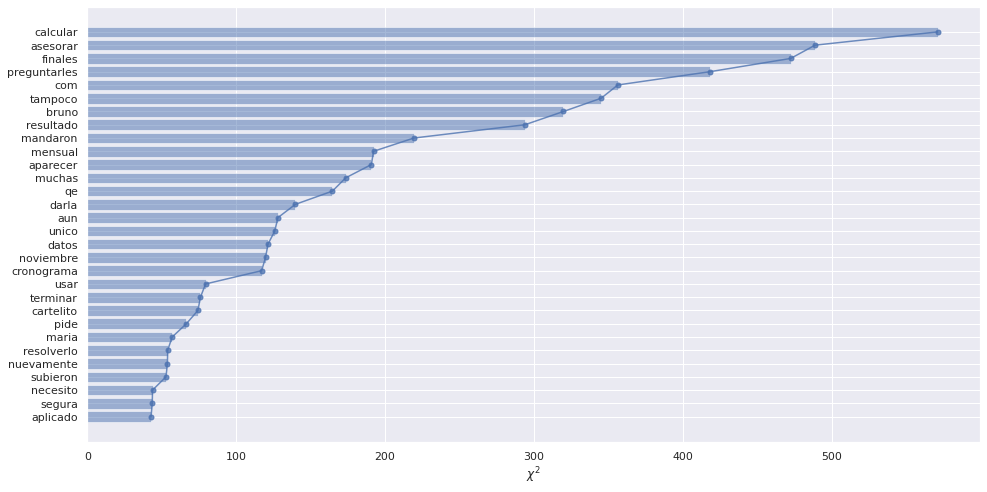

In [ ]:
# Analizo cuales son las features mas importantes según chi2

from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
%matplotlib inline

chi2score = chi2(x, y)[0]

plt.figure(figsize=(16,8))

scores = list(zip(representacion.get_feature_names(), chi2score))

chi2 = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2[-30:]))
x_chi = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x_chi, topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x_chi, '-o', markersize=5, alpha=0.8)
plt.yticks(x_chi, labels)
plt.xlabel('$\chi^2$')
plt.show();

In [ ]:
# Separo datos de entrenamiento y testing

from sklearn.model_selection import train_test_split

# Separo en 70-30 entrenamiento y testeo
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size=0.3)


## Naive Bayes

Aquí probamos con Naive Bayes (Usamos ComplementNB que posee optimizaciones para datasets desbalanceados):

In [ ]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB

modelo_bayes = ComplementNB()

modelo_bayes.fit(x_train, y_train)

# Realizo la predicción de y con el x_test
y_pred = modelo_bayes.predict(x_test)

In [ ]:
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8166666666666667


## Máquina Vector-Soporte (SVM):

Ahora corremos el segundo modelo:

In [ ]:
from sklearn.svm import LinearSVC

modelo_svc = LinearSVC(max_iter=600)
modelo_svc.fit(x_train, y_train)

# Realizo la predicción de y con el x_test
y_pred = modelo_svc.predict(x_test)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8366666666666667


In [ ]:
from sklearn.svm import SVC

modelo_svc = SVC(max_iter=600)
modelo_svc.fit(x_train, y_train)

# Realizo la predicción de y con el x_test
y_pred = modelo_svc.predict(x_test)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8433333333333334


## Regresión Logística

Aquí corremos el tercer modelo:

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

modelo_regresion = LogisticRegression(max_iter=10000)
modelo_regresion.fit(x_train, y_train)

# Realizo la predicción de y con el x_test
y_pred = modelo_regresion.predict(x_test)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.88


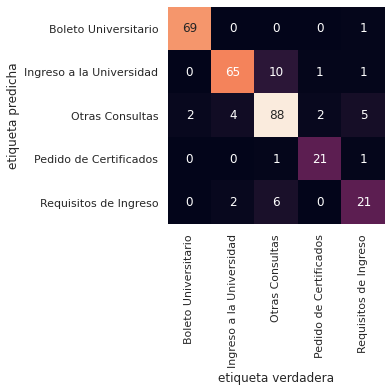

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('etiqueta verdadera')
plt.ylabel('etiqueta predicha');

## Árboles de clasificación (Bonus track)

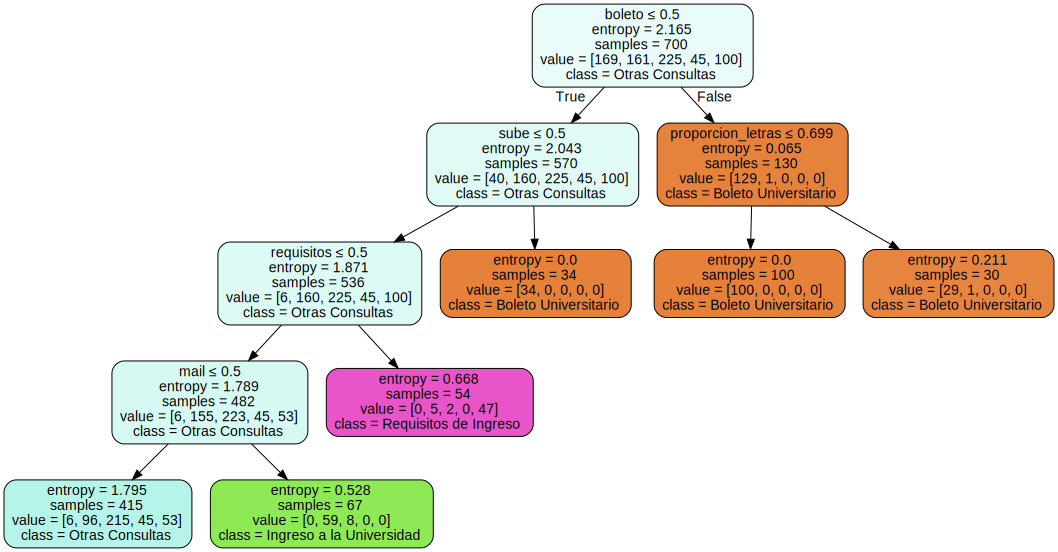

<Figure size 1152x576 with 0 Axes>

In [ ]:
from sklearn import tree

arbol = tree.DecisionTreeClassifier(criterion='entropy',  max_depth=4, min_samples_leaf=30)

arbol = arbol.fit(x_train, y_train)

#Importamos la librería
import graphviz

plt.figure(figsize=(16,8))

dot_data = tree.export_graphviz(arbol, out_file=None,
                                feature_names=x_train.columns,
                                class_names=target_names,
                                label='all',
                                filled=True, rounded=True,
                                special_characters=True)

# Capturo el source
graph = graphviz.Source(dot_data)

# Muestro el contenido de graph
graph

In [ ]:
#Predict the response for test dataset
y_pred = arbol.predict(x_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.74
